Importamos las librerías necesarias


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.fftpack import fft, fftfreq
from scipy.signal import cheby1, sosfilt

Generamos la señal como una función senoidal/cosenoidal usando parámetros como frecuencia, fase y la serie de tiempo

In [40]:
def func(time_series, frequencies, phases):
    s = np.zeros_like(time_series)
    w = 2 * np.pi
    for f,p in zip(frequencies, phases):
        s += np.cos(w * time_series * f + p)
    return s

Realizamos el muestreo tomando como referencia el valor de frecuencia máximo de la señal a muestrear

In [41]:
n_samples = 600
freqs = np.random.randint(1, 50, 4)
# freqs = [5, 10, 15, 20]
phases = [np.pi/3, 0.5, 1, 2 * np.pi * 30]

sample_rate = max(freqs) * 3

time = np.arange(0, n_samples) * (1 / sample_rate)

signal = func(time, freqs, phases)

Usamos una versión de la misma señal con un sample rate más alto para "simular" la señal análoga original y realizar comparaciones (Usando el 95% del numero total de muestras como referencia).

In [42]:
fs_ideal = int(n_samples * 0.95)
time_ideal = np.arange(0, n_samples) * (1 / fs_ideal)
signal_ideal = func(time_ideal, freqs, phases)

Generamos un plot con las muestras obtenidas dibujadas sobre la señal ideal.

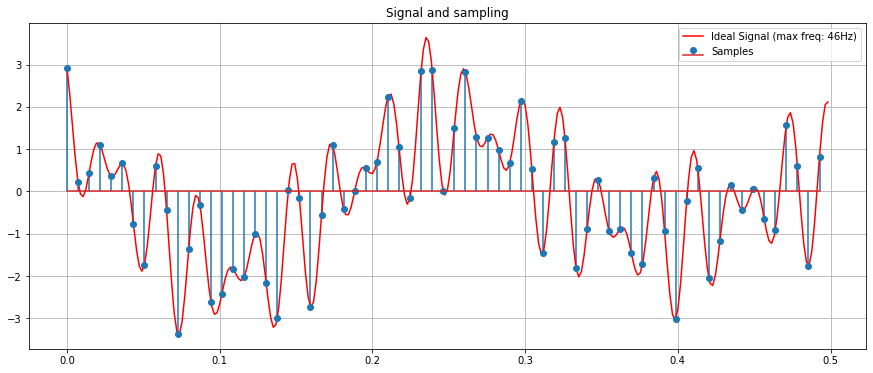

In [43]:

plt.figure(figsize=(15,6))
plt.plot(time_ideal[:fs_ideal//2], signal_ideal[:fs_ideal//2], 'r', label=f'Ideal Signal (max freq: {max(freqs)}Hz)')

plt.stem(time[:sample_rate//2], signal[:sample_rate//2], label=f'Samples')

plt.grid(True)
plt.legend(loc='best')
plt.title('Signal and sampling')
plt.show()

Generamos un segundo plot con la señal reconstruida a partir de las muestras. La librería aplica interpolación lineal por defecto para generar las curvas de la función.

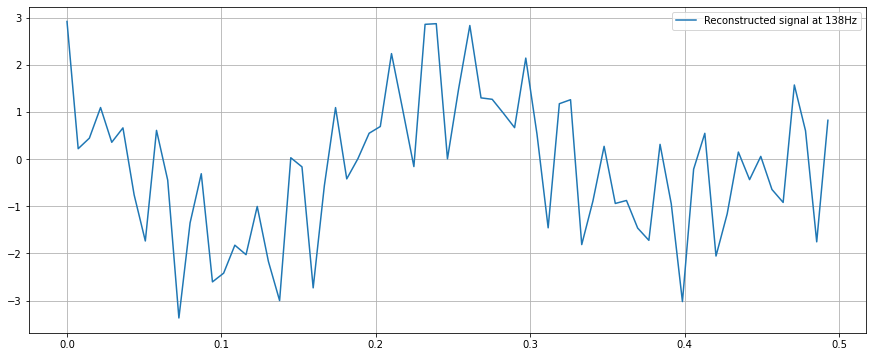

In [44]:
plt.figure(figsize=(15,6))
plt.plot(time[:sample_rate//2], signal[:sample_rate//2], label=f'Reconstructed signal at {sample_rate}Hz')
plt.grid(True)
plt.legend(loc='best')
plt.show()

Normalizamos la señal para un rango de valores (Determinado por el número de bits que usaremos para digitalizarla). En este caso, usaremos un formato de 8 bits sin valores negativos

In [45]:
n_bits = 8

vmin = 0
vmax = int(2**n_bits) - 1

signal_vmax = np.max(signal)
signal_vmin = np.min(signal)

normal_signal = vmin + ((signal - signal_vmin) * (vmax - vmin))/(signal_vmax - signal_vmin)

Para obtener la función discretizada, aplicamos interpolación usando el algoritmo de vecinos cercanos. Esto dará la forma de señal escalonada característico de las señales digitalizadas, pero tendremos que aumentar el sample rate a cambio.

In [46]:
aug_rate = 20
augmented_time = np.arange(0,len(time) * aug_rate) * np.max(time) /(len(time) * aug_rate)

digital_signal = np.around(normal_signal)
interpolated = interpolate.interp1d(time, digital_signal, kind='nearest')(augmented_time)

Se crea una versión normalizada de la señal ideal (simulación de la original) para ajustarla a la escala de la señal interpolada digital

In [47]:
alt_signal_ideal = vmin + ((signal_ideal - signal_vmin) * (vmax - vmin))/(signal_vmax - signal_vmin)

Se genera un plot con ambas señales

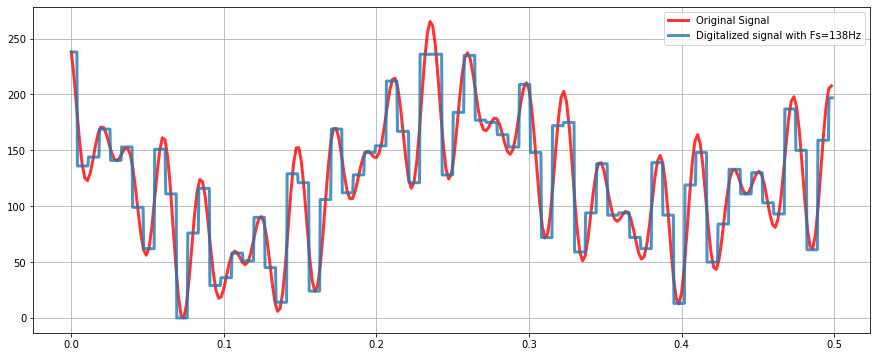

In [48]:
plt.figure(figsize=(15,6))
plt.plot(time_ideal[:fs_ideal//2], alt_signal_ideal[:fs_ideal//2], 'r', label='Original Signal', linewidth=3, alpha=0.8)
plt.plot(augmented_time[:sample_rate*aug_rate//2], interpolated[:sample_rate*aug_rate//2], label=f'Digitalized signal with Fs={sample_rate}Hz', linewidth=3, alpha = 0.8)

plt.grid(True)
plt.legend(loc='best')
plt.show()

Se calcula el error de cuantización a partir de la diferencia de entre la señal digitalizada y la "original" normalizada

In [49]:
error = abs(digital_signal - normal_signal)

Representación gráfica del error de cuantización

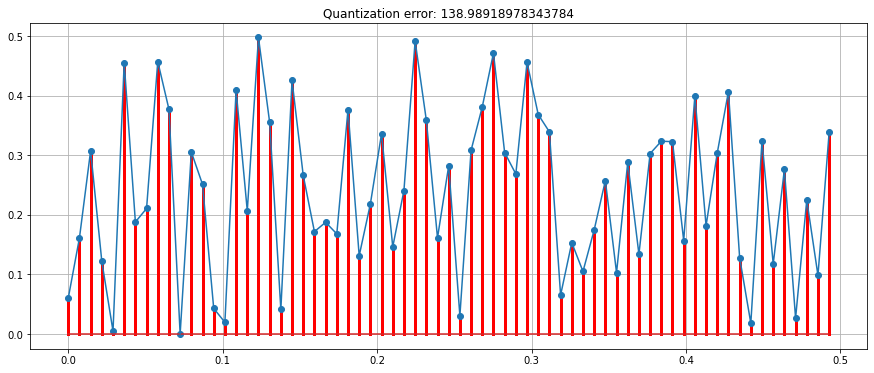

In [50]:
plt.figure(figsize=(15,6))
for p,t in zip(error[:sample_rate//2], time[:sample_rate//2]):
    plt.plot([t, t], [0, p], 'r', linewidth=3)
    
plt.stem(time[:sample_rate//2], error[:sample_rate//2])

plt.plot(time[:sample_rate//2], error[:sample_rate//2])

plt.title(f'Quantization error: {np.sum(error)}')
plt.grid(True)
plt.show()

Primeras muestras de los vectores de las señales, error y la codificación binaria

In [51]:
digits = 20
digital_signal = np.uint8(digital_signal)
print('______________________________________________________________________________________')
print('Normal signal\t\tQuantization code\tQuantization error\tEncoded Word')
print('______________________________________________________________________________________')
for normal, code, e in zip(normal_signal[:digits], digital_signal[:digits], error[:digits]):
    print(f'{normal}\t\t{code}\t\t{e}\t{bin(code)}')

______________________________________________________________________________________
Normal signal		Quantization code	Quantization error	Encoded Word
______________________________________________________________________________________
237.93991003710158		238		0.060089962898416616	0b11101110
135.83888379964412		136		0.16111620035587748	0b10001000
144.30770137888013		144		0.3077013788801253	0b10010000
168.87809330945456		169		0.12190669054544401	0b10101001
140.9950995725964		141		0.004900427403612184	0b10001101
152.54440987157435		153		0.45559012842565494	0b10011001
98.8120419430578		99		0.18795805694219325	0b1100011
61.78931622851493		62		0.21068377148507267	0b111110
150.54253491428628		151		0.45746508571372146	0b10010111
110.62276871360831		111		0.3772312863916909	0b1101111
1.3107552503914253e-12		0		1.3107552503914253e-12	0b0
76.30556344208397		76		0.30556344208396524	0b1001100
115.748824705088		116		0.2511752949120023	0b1110100
28.95710182514804		29		0.04289817485195968	0b11101
3

Aplicamos la Transformada de Fourier para obtener el espectro de frecuencia de nuestra señal

In [52]:
ft_interpolated = fft(interpolated)
ft_signal_ideal = fft(signal_ideal)

freqs_interp = fftfreq(len(ft_interpolated), 1/(sample_rate * aug_rate))
freqs_ideal = fftfreq(len(ft_signal_ideal), 1/(fs_ideal))

Generamos el plot con los espectros (parte real) para observar que, además de conservar las frecuencias fundamentales, la versión digitalizada posee ciertos picos

array([46,  4,  3, 34])

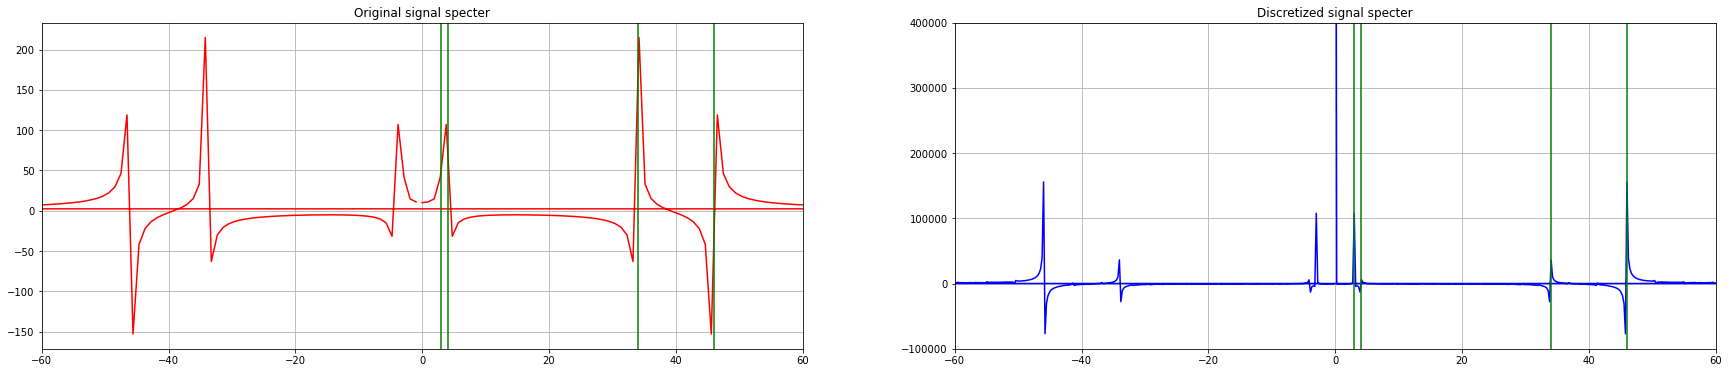

In [53]:
plt.figure(figsize=(30,6))
plt.subplot(1, 2, 1)
plt.title('Original signal specter')
plt.plot(freqs_ideal, ft_signal_ideal.real, 'r')
for f in freqs:
    plt.axvline(x = f, color='g')
plt.xlim(left = -60, right = 60)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Discretized signal specter')
plt.xlim(left = -60, right = 60)
plt.ylim(top = 0.4e6, bottom=-0.1e6)
plt.plot(freqs_interp, ft_interpolated.real, 'b')
for f in freqs:
    plt.axvline(x = f, color='g')
plt.grid(True)

freqs

Aplicamos un filtro digital Chebysehv de 3er orden para eliminar las frecuencias excedentes formadas durante la digitalización (Las altas frecuencias en particular)

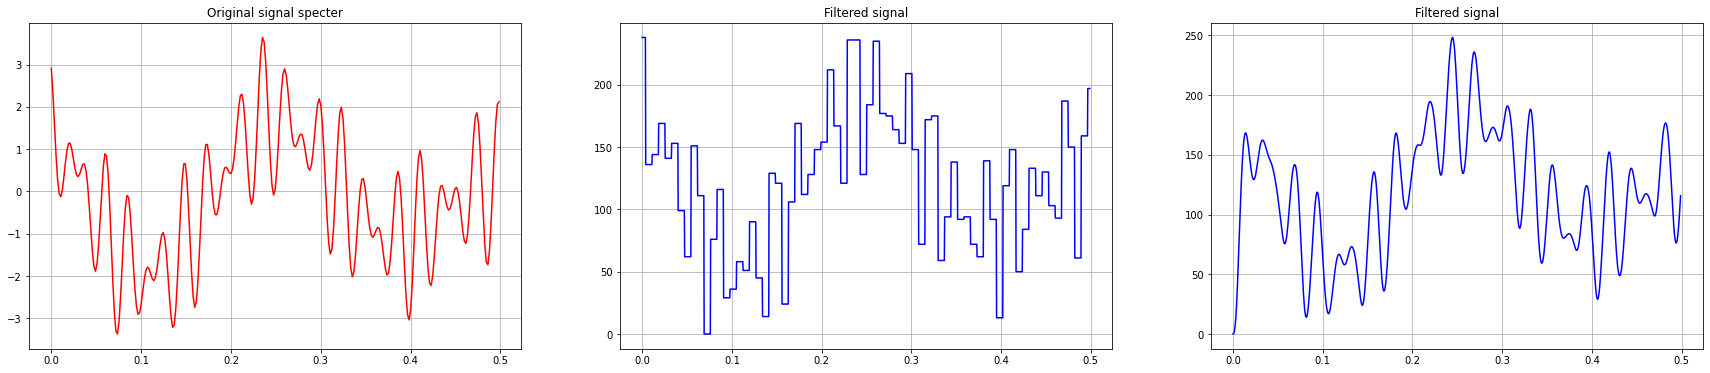

In [54]:
max_freq = np.max(freqs)

sos = cheby1(3, 1, max_freq, fs=sample_rate * aug_rate, btype='lowpass', output='sos',)

filtered = sosfilt(sos, interpolated)
filtered = filtered + abs(np.min(filtered))

plt.figure(figsize=(30,6))

plt.subplot(1, 3, 1)
plt.title('Original signal specter')
plt.plot(time_ideal[:fs_ideal//2], signal_ideal[:fs_ideal//2], 'r')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.title('Filtered signal')
plt.plot(augmented_time[:aug_rate*sample_rate//2], interpolated[:aug_rate*sample_rate//2], 'b')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.title('Filtered signal')
plt.plot(augmented_time[:aug_rate*sample_rate//2], filtered[:aug_rate*sample_rate//2], 'b')
plt.grid(True)


Se genera el plot para el espectro de la señal filtrada

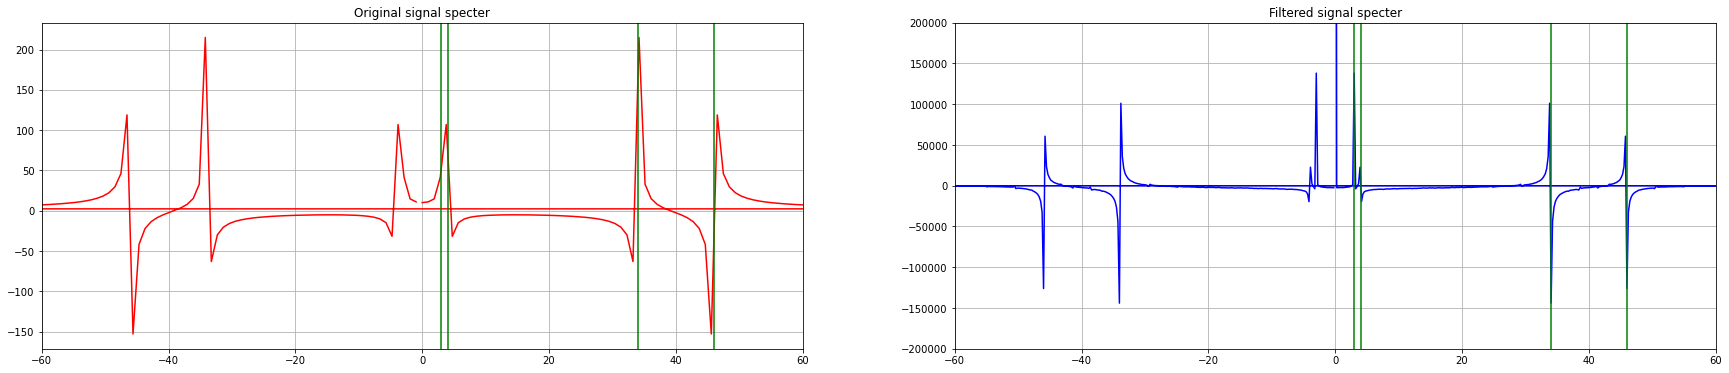

In [55]:
ft_filtered = (fft(filtered))

plt.figure(figsize=(30,6))
plt.subplot(1, 2, 1)
plt.title('Original signal specter')
plt.plot(freqs_ideal, ft_signal_ideal.real, 'r')
for f in freqs:
    plt.axvline(x = f, color='g')
plt.xlim(left = -60, right = 60)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Filtered signal specter')
plt.xlim(left = -60, right = 60)
plt.ylim(top = 0.2e6, bottom=-0.2e6)
plt.plot(freqs_interp, ft_filtered.real, 'b')
for f in freqs:
    plt.axvline(x = f, color='g')
plt.grid(True)

SNR para la señal digitalizada en base a la cantidad de bits usados para su representación

In [56]:
SNRdB = 6.02 * (n_bits) + 1.76
SNRdB

49.919999999999995